In [2]:
%config InlineBackend.figure_format = 'retina'

In [82]:
import numpy as np
from pathlib import Path
import re
import time
import warnings

from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astropy.nddata import CCDData
import astroscrappy
import astroalign as aa
from ccdproc import combine
from matplotlib import pyplot as plt

plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14

In [11]:
# setting locations
DATADIR = Path('./data/reduc/2024-03-20')
RAWDIR = DATADIR / 'raw'
OUTDIR = DATADIR/ 'reduced'

# making output directory if it doesn't exist
if not OUTDIR.exists():
    OUTDIR.mkdir()

In [63]:
def make_summary_table(rawdir: Path):
    # making a summary table
    summary = []
    for f in rawdir.glob('*.fit'):
        hdr = fits.getheader(f)
        # getting the filter information
        # - SAO doesn't have a filter keyword, so we need to look at the filename
        # - checking for the filter in the filename with regex
        filt = 'unknown'
        if 'filter' in hdr:
            filt = hdr['filter']
        elif 'FILTER' in hdr:
            filt = hdr['FILTER']
        else:
            mtch = re.search(r'[UBVRIgriz].fit$', f.name)
            mtch_Ha = re.search(r'Ha.fit$', f.name)
            if mtch:
                filt = mtch.group(0)[0]
            elif mtch_Ha:
                filt = 'Ha'
            
        # getting the airmass X (Pickering 2002)
        try:
            alt = float(hdr['OBJCTALT'])
            X = 1/(np.sin(np.radians( alt + 244/(165 + 47*alt**1.1 ))))
        except TypeError:
            X = -1
        except Exception as e:
            print(f'Error in {f.name}: {e}')
            X = -1
        
        summary.append([f.name, hdr['DATE-OBS'], hdr['OBJECT'],
                        hdr['OBJCTRA'], hdr['OBJCTDEC'],
                        hdr['IMAGETYP'], hdr['EXPTIME'],
                        X, filt])
        stab = Table(rows=summary,
                     names=['filename', 'date-obs', 'object', 'ra', 'dec',
                            'imagetyp', 'exptime', 'airmass', 'filter'],
                     # str, str, str, float, float, str, float, float, str
                     dtype=['U50', 'U50', 'U50', 'U50', 'U50', 'U50', 'f8', 'f8', 'U50'])
    return stab

In [70]:
# making the summary table
summary_table = make_summary_table(RAWDIR)
# sorting the table by date
summary_table.sort('date-obs')
# showing the table
summary_table.show_in_notebook(display_length=5)

idx,filename,date-obs,object,ra,dec,imagetyp,exptime,airmass,filter
0,skyflat-0001Ha.fit,2024-03-20T09:22:27,skyflat,07 43 57,+60 34 21,Flat Field,3.0,1.152217579019225,Ha
1,skyflat-0002Ha.fit,2024-03-20T09:22:42,skyflat,07 44 13,+60 34 21,Flat Field,3.0,1.1522164291076638,Ha
2,skyflat-0003Ha.fit,2024-03-20T09:22:57,skyflat,07 44 28,+60 34 22,Flat Field,3.0,1.152217579019225,Ha
3,skyflat-0004Ha.fit,2024-03-20T09:23:12,skyflat,07 44 43,+60 34 22,Flat Field,3.0,1.1522187289365808,Ha
4,skyflat-0005Ha.fit,2024-03-20T09:23:27,skyflat,07 44 58,+60 34 22,Flat Field,3.0,1.1522187289365808,Ha
5,skyflat-0006Ha.fit,2024-03-20T09:23:42,skyflat,07 45 13,+60 34 23,Flat Field,3.0,1.1522187289365808,Ha
6,skyflat-0007Ha.fit,2024-03-20T09:23:57,skyflat,07 45 28,+60 34 23,Flat Field,3.0,1.152217579019225,Ha
7,skyflat-0001z.fit,2024-03-20T09:25:16,skyflat,07 46 46,+60 34 26,Flat Field,2.0,1.1522141293019248,z
8,skyflat-0002z.fit,2024-03-20T09:25:30,skyflat,07 47 00,+60 34 26,Flat Field,2.0,1.1522164291076638,z
9,skyflat-0003z.fit,2024-03-20T09:25:45,skyflat,07 47 14,+60 34 27,Flat Field,2.0,1.1522164291076638,z


In [68]:
# table for each type of frame
bias_table = summary_table[summary_table['imagetyp'] == 'Bias Frame']
dark_table = summary_table[summary_table['imagetyp'] == 'Dark Frame']
flat_table = summary_table[summary_table['imagetyp'] == 'Flat Field']
sci_table = summary_table[summary_table['imagetyp'] == 'Light Frame']

# counting the number of frames
print(f'Number of bias frames: {len(bias_table)}')
print(f'Number of dark frames: {len(dark_table)}')
print(f'Number of flat frames: {len(flat_table)}')
print(f'Number of flat frames with g-band: {len(flat_table[flat_table["filter"] == "g"])}')
print(f'Number of science frames: {len(sci_table)}')
print(f'Number of science frames with g-band: {len(sci_table[sci_table["filter"] == "g"])}')

Number of bias frames: 5
Number of dark frames: 15
Number of flat frames: 35
Number of flat frames with g-band: 7
Number of science frames: 12
Number of science frames with g-band: 3


In [98]:
# test reading of science frame
fname = RAWDIR / sci_table['filename'][0]
hdu = fits.open(fname)
isci = 0
sci = hdu[isci].data   # 2D image array of pixel counts
hdr = hdu[isci].header # image header information

# simple visulization of the image
ibias, idark, iflat = 0, 0, 4
bias = fits.getdata(RAWDIR / bias_table['filename'][ibias])
dark = fits.getdata(RAWDIR / dark_table['filename'][idark])
flat = fits.getdata(RAWDIR / flat_table['filename'][iflat])

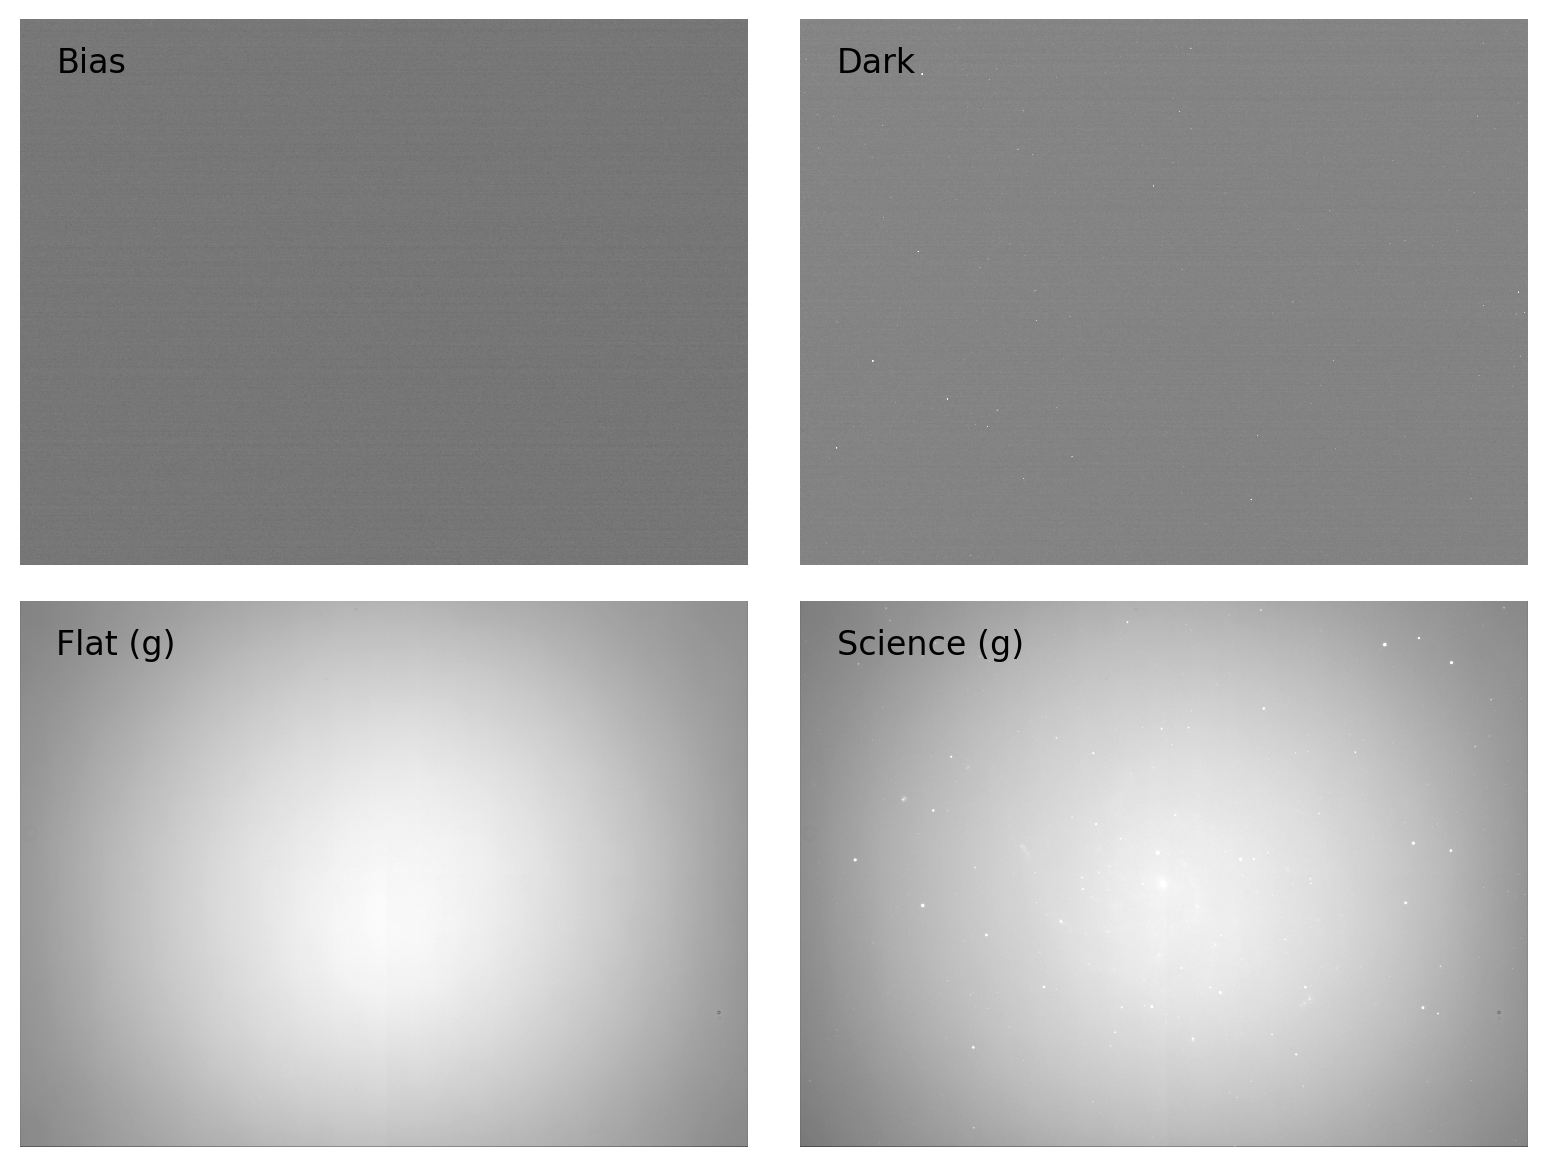

In [99]:
# for displaying in zscale
interval = ZScaleInterval()

# plotting the images
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
titles = ['Bias', 'Dark', f'Flat ({flat_table['filter'][iflat]})',
          f'Science ({sci_table['filter'][isci]})']
for i, img in enumerate([bias, dark, flat, sci]):
    vmin, vmax = interval.get_limits(img)
    ax = axes[i // 2][i % 2]
    ax.imshow(img, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    ax.text(0.05, 0.95, titles[i], transform=ax.transAxes, ha='left', va='top')
    ax.axis('off')
plt.tight_layout()

$$\sigma_{\rm ADU} = \frac{\rm Readout\ noise}{\rm Gain}$$

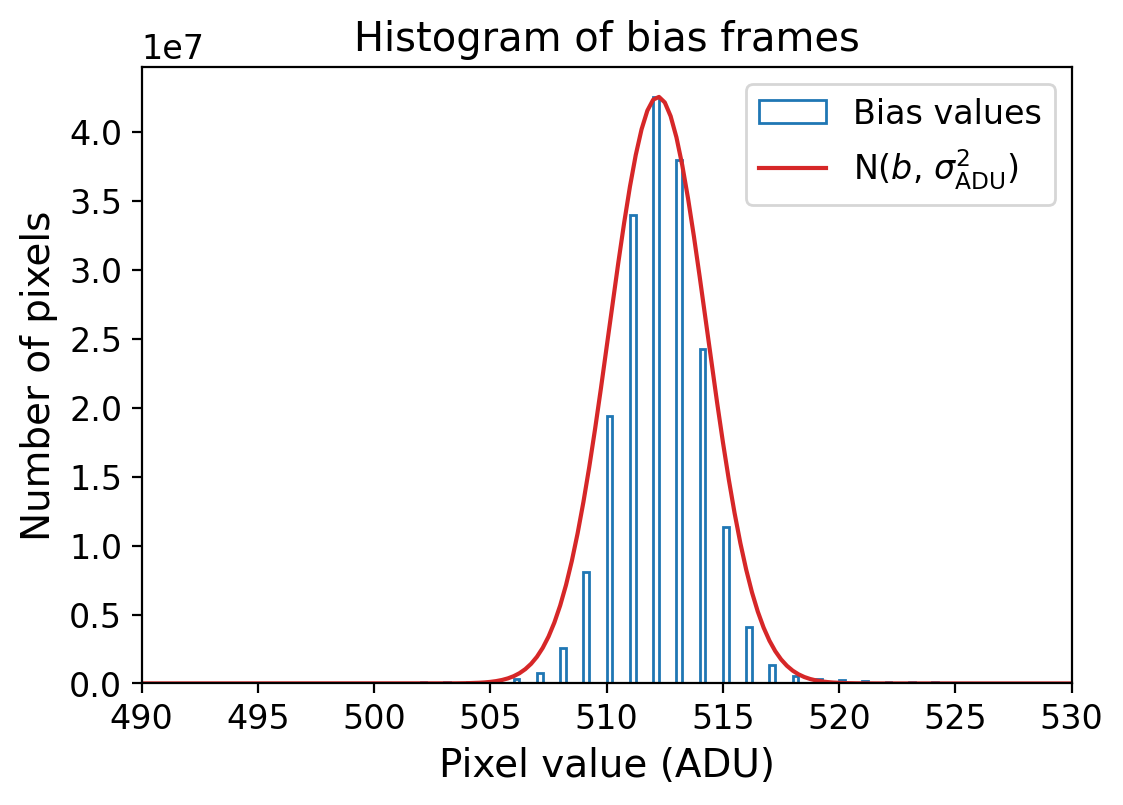

In [159]:
# get readout noise from bias frames
bias_imgs = np.array([fits.getdata(RAWDIR/f) for f in bias_table['filename']])

# bring gain
gain = fits.getheader(RAWDIR / bias_table['filename'][0])['EGAIN'] # e-/ADU

# calculate the readout noise
bias_level = np.mean(bias_imgs.ravel())
sig_adu = np.std(bias_imgs, ddof=1) # ADU
rdnoise = sig_adu * gain # e-


fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
y, x, _ = ax.hist(np.ravel(bias_imgs), bins=500, histtype='step',
               label='Bias values')
# Gaussian model for comparison
gaussian = np.exp(-0.5 * ((x - bias_level) / sig_adu)**2) * np.max(y)
ax.plot(x, gaussian, c='tab:red', label=r'N($b$, $\sigma_{\rm ADU}^2$)')
ax.set_xlabel('Pixel value (ADU)')
ax.set_ylabel('Number of pixels')
ax.set_xlim(490, 530)
ax.set_title('Histogram of bias frames')
ax.legend()